# Exploratory Data Analysis (EDA) - FER-2013 Emotion Dataset


## Setup and Data Loading


In [ ]:
import os, json, glob, textwrap, hashlib, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
#import imagehash
import cv2
from tqdm import tqdm
import seaborn as sns

# Configuration
BASE_DIR = Path("../../data/raw/fer2013") 
TRAIN_DIR = BASE_DIR / "train"
TEST_DIR = BASE_DIR / "test"
SELECTED_CLASSES = ["angry", "happy", "sad", "surprise", "neutral"]
DROPPED_CLASSES = ["fear", "disgust"]

# --- EDA / MobileNet settings
IMG_SIZE   = 224       
CHANNELS   = 3         
ARTIFACTS  = Path("./artifacts/eda")
ARTIFACTS.mkdir(parents=True, exist_ok=True)

LABEL2ID = {c:i for i,c in enumerate(SELECTED_CLASSES)}
ID2LABEL = {i:c for c,i in LABEL2ID.items()}

print("Config OK:", {
    "BASE_DIR": str(BASE_DIR),
    "SELECTED_CLASSES": SELECTED_CLASSES,
    "IMG_SIZE": IMG_SIZE,
    "CHANNELS": CHANNELS
})

Config OK: {'BASE_DIR': '..\\..\\data\\raw\\fer2013', 'SELECTED_CLASSES': ['angry', 'happy', 'sad', 'surprise', 'neutral'], 'IMG_SIZE': 224, 'CHANNELS': 3}


## Dataset Summary

In [45]:
def count_images(directory):
    counts = {}
    for emotion in os.listdir(directory):
        emotion_path = os.path.join(directory, emotion)
        if os.path.isdir(emotion_path):
            counts[emotion] = len(os.listdir(emotion_path))
    return counts

train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)

df_train = pd.DataFrame(list(train_counts.items()), columns=["Emotion", "Train Images"])
df_test = pd.DataFrame(list(test_counts.items()), columns=["Emotion", "Test Images"])
df_summary = pd.merge(df_train, df_test, on="Emotion", how="outer").fillna(0)
print(df_summary)

    Emotion  Train Images  Test Images
0     angry          3995          958
1   disgust           436          111
2      fear          4097         1024
3     happy          7215         1774
4   neutral          4965         1233
5       sad          4830         1247
6  surprise          3171          831


## Class Distribution Visualization

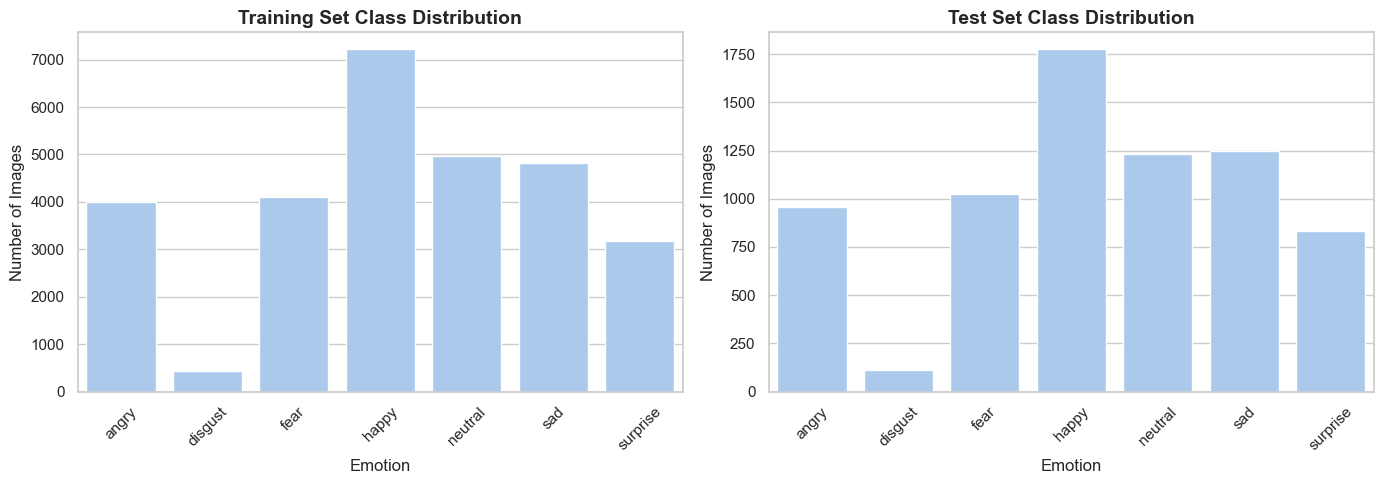

In [46]:
# Class Distribution Visualization (Train vs Test)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.set(style="whitegrid", palette="pastel")

# Training Set
sns.barplot(ax=axes[0], x="Emotion", y="Train Images", data=df_summary)
axes[0].set_title("Training Set Class Distribution", fontsize=14, weight='bold')
axes[0].set_xlabel("Emotion", fontsize=12)
axes[0].set_ylabel("Number of Images", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Test Set
sns.barplot(ax=axes[1], x="Emotion", y="Test Images", data=df_summary)
axes[1].set_title("Test Set Class Distribution", fontsize=14, weight='bold')
axes[1].set_xlabel("Emotion", fontsize=12)
axes[1].set_ylabel("Number of Images", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



## Pixel Intensity Analysis

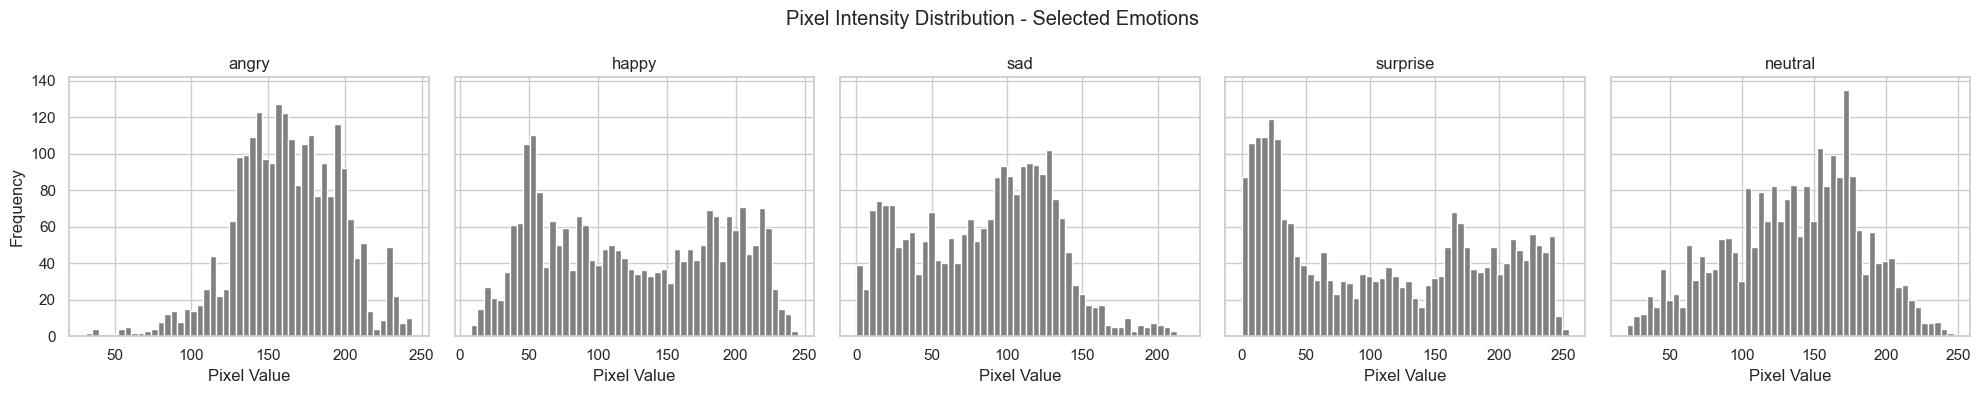

In [47]:
fig, axes = plt.subplots(1, len(SELECTED_CLASSES), figsize=(20, 4), sharey=True)
for idx, emotion in enumerate(SELECTED_CLASSES):
    emotion_dir = TRAIN_DIR / emotion
    img_name = random.choice(os.listdir(emotion_dir))
    img_path = emotion_dir / img_name
    img = np.array(Image.open(img_path))
    axes[idx].hist(img.flatten(), bins=50, color='gray')
    axes[idx].set_title(emotion)
    axes[idx].set_xlabel("Pixel Value")
axes[0].set_ylabel("Frequency")
fig.suptitle("Pixel Intensity Distribution - Selected Emotions")
plt.tight_layout()
plt.show()


## Image- Level Statistics

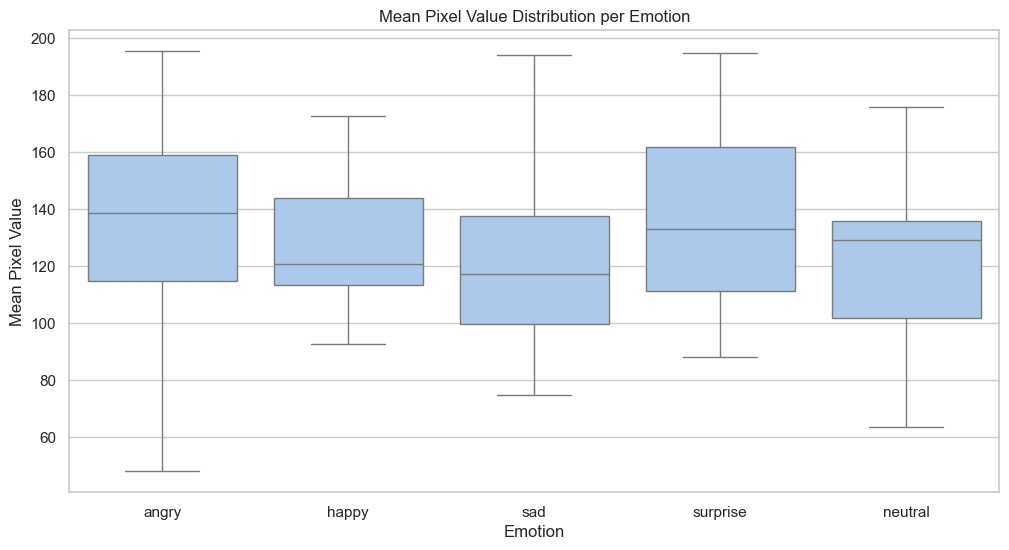

In [48]:
means = []
stds = []
labels = []

for emotion in SELECTED_CLASSES:
    emotion_dir = TRAIN_DIR / emotion
    sample_files = random.sample(os.listdir(emotion_dir), min(20, len(os.listdir(emotion_dir))))
    for img_name in sample_files:
        img_path = emotion_dir / img_name
        img = np.array(Image.open(img_path))
        means.append(img.mean())
        stds.append(img.std())
        labels.append(emotion)

stats_df = pd.DataFrame({"Emotion": labels, "Mean Pixel Value": means, "Std Pixel Value": stds})
plt.figure(figsize=(12,6))
sns.boxplot(x="Emotion", y="Mean Pixel Value", data=stats_df)
plt.title("Mean Pixel Value Distribution per Emotion")
plt.show()

## Helpers

In [ ]:
def list_images(split_dir: Path, split_name: str):
    rows = []
    if not split_dir.exists():
        return pd.DataFrame(columns=["split","label","path"])
    for cls in sorted(os.listdir(split_dir)):
        cdir = split_dir / cls
        if not cdir.is_dir(): 
            continue
        for fp in glob.glob(str(cdir / "*")):
            if fp.lower().endswith((".png",".jpg",".jpeg",".bmp")):
                rows.append((split_name, cls, fp))
    return pd.DataFrame(rows, columns=["split", "label", "path"])

def is_readable_gray(path: str) -> bool:
    try:
        img = Image.open(path).convert("L")
        img.verify()  
        return True
    except Exception:
        return False

def to_rgb_resized_numpy(path: str, size: int = IMG_SIZE):
    im = Image.open(path).convert("L")
    im_rgb = ImageOps.grayscale(im).convert("RGB")  # replicate L->RGB
    im_rgb = im_rgb.resize((size, size), resample=Image.BICUBIC)
    return np.asarray(im_rgb)

def variance_of_laplacian_gray(path: str):
    if not HAS_CV2:
        return np.nan
    im = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if im is None:
        return np.nan
    return cv2.Laplacian(im, cv2.CV_64F).var()


## Scan dataset, keep only selected classes, drop unreadable

In [ ]:
df_train = list_images(TRAIN_DIR, "train")
df_test  = list_images(TEST_DIR,  "test")

df = pd.concat([df_train, df_test], ignore_index=True)

print("Raw counts (all labels found):")
display(df.groupby(["split","label"]).size().unstack(fill_value=0))

found_dropped = sorted(set(df["label"]) & set(DROPPED_CLASSES))
if found_dropped:
    print("Note: images exist for DROPPED classes:", found_dropped)

df = df[df["label"].isin(SELECTED_CLASSES)].reset_index(drop=True)

bad = []
for p in tqdm(df["path"], desc="Verifying images"):
    if not is_readable_gray(p):
        bad.append(p)
if bad:
    pd.Series(bad).to_csv(ARTIFACTS/"unreadable_files.csv", index=False, header=False)
    print(f"Unreadable images removed: {len(bad)} (saved to unreadable_files.csv)")
df = df[~df["path"].isin(bad)].reset_index(drop=True)

print("Filtered counts (selected classes only):")
display(df.groupby(["split","label"]).size().unstack(fill_value=0))

df.to_csv(ARTIFACTS/"index_selected.csv", index=False)


Raw counts (all labels found):


label,angry,disgust,fear,happy,neutral,sad,surprise
split,,,,,,,
test,958,111,1024,1774,1233,1247,831
train,3995,436,4097,7215,4965,4830,3171


Note: images exist for DROPPED classes: ['disgust', 'fear']


Verifying images: 100%|██████████| 30219/30219 [00:07<00:00, 3894.39it/s]

Filtered counts (selected classes only):


label,angry,happy,neutral,sad,surprise
split,,,,,
test,958,1774,1233,1247,831
train,3995,7215,4965,4830,3171


## Per-split distributions (tables + bars)

split,test,train,total
label,,,
angry,958.0,3995.0,4953.0
happy,1774.0,7215.0,8989.0
neutral,1233.0,4965.0,6198.0
sad,1247.0,4830.0,6077.0
surprise,831.0,3171.0,4002.0
__TOTAL__,6043.0,24176.0,30219.0


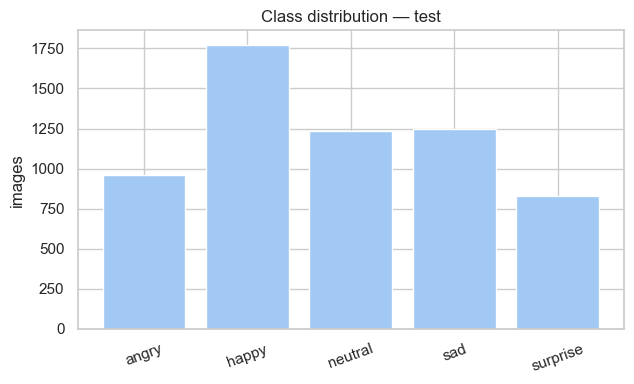

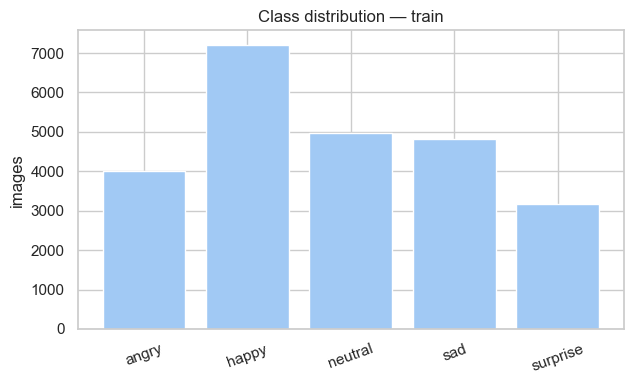

In [51]:
def plot_counts(df_in, title_prefix, out_prefix):
    counts = (df_in.groupby(["split","label"])
                    .size()
                    .reset_index(name="count"))
    pivot = counts.pivot(index="label", columns="split", values="count").fillna(0).astype(int)
    pivot["total"] = pivot.sum(axis=1)
    pivot.loc["__TOTAL__", :] = pivot.sum(axis=0)
    
    display(pivot)
    pivot.to_csv(ARTIFACTS/f"{out_prefix}_counts.csv")

    for sp in sorted(df_in["split"].unique()):
        sub = counts[counts["split"]==sp]
        plt.figure(figsize=(6.5,4))
        plt.title(f"{title_prefix} — {sp}")
        plt.bar(sub["label"], sub["count"])
        plt.xticks(rotation=20)
        plt.ylabel("images")
        plt.tight_layout()
        plt.savefig(ARTIFACTS/f"{out_prefix}_bar_{sp}.png", dpi=160)
        plt.show()

plot_counts(df, "Class distribution", "class_distribution")


In [52]:
train_names = set(Path(p).name for p in df[df["split"]=="train"]["path"])
test_names  = set(Path(p).name for p in df[df["split"]=="test"]["path"])
overlap = sorted(train_names & test_names)
print(f"Filename overlaps between train and test: {len(overlap)}")
if overlap:
    pd.Series(overlap).to_csv(ARTIFACTS/"filename_overlap_train_test.csv", index=False, header=False)


Filename overlaps between train and test: 0


## Sample Images

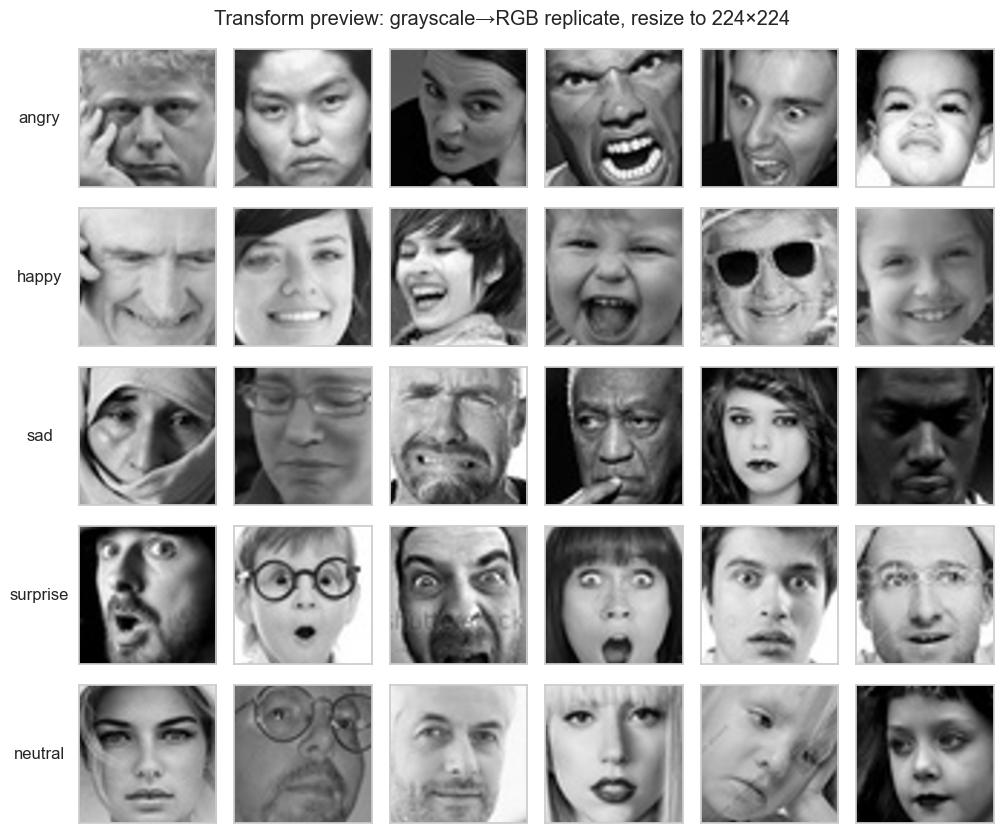

In [ ]:
SAMPLES_PER_CLASS = 6
random.seed(7)

grid = []
grid_labels = []
for cls in SELECTED_CLASSES:
    paths = df[(df["split"]=="train") & (df["label"]==cls)]["path"].tolist()
    if not paths:
        paths = df[df["label"]==cls]["path"].tolist()
    paths = random.sample(paths, min(SAMPLES_PER_CLASS, len(paths)))
    for p in paths:
        img = to_rgb_resized_numpy(p, IMG_SIZE)  
        grid.append(img); grid_labels.append(cls)

if grid:
    rows = len(SELECTED_CLASSES)
    cols = SAMPLES_PER_CLASS
    plt.figure(figsize=(1.7*cols, 1.7*rows))
    for i, img in enumerate(grid[:rows*cols]):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img)
        ax.set_xticks([]); ax.set_yticks([])
        if i % cols == 0:
            ax.set_ylabel(grid_labels[i], rotation=0, labelpad=28, va='center')
    plt.suptitle(f"Transform preview: grayscale→RGB replicate, resize to {IMG_SIZE}×{IMG_SIZE}")
    plt.tight_layout()
    plt.savefig(ARTIFACTS/"transform_preview.png", dpi=180)
    plt.show()


## Pixel histograms

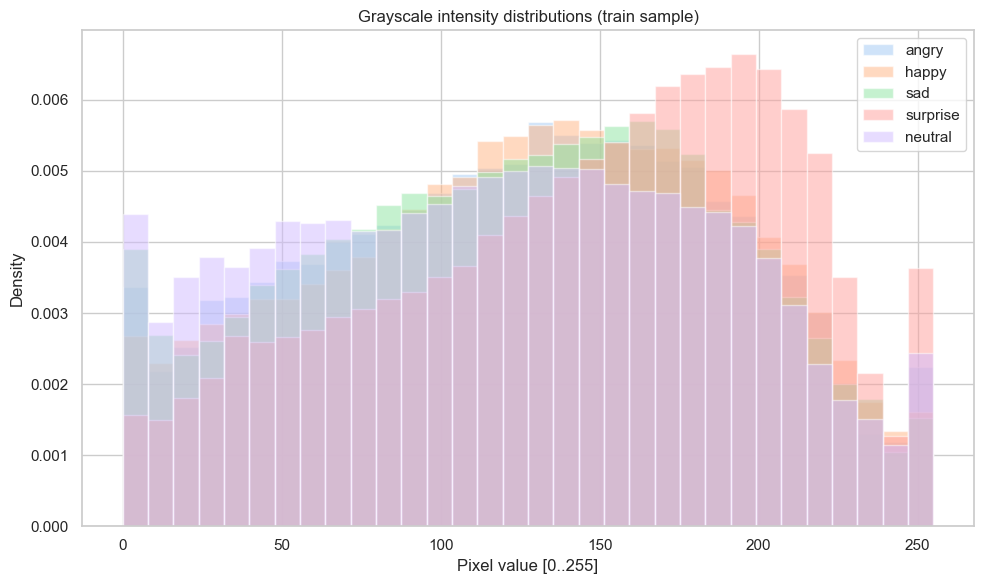

In [54]:
sub = df[df["split"]=="train"] if "train" in df["split"].unique() else df
hist_data = {c:[] for c in SELECTED_CLASSES}

for cls in SELECTED_CLASSES:
    paths = sub[sub["label"]==cls]["path"].tolist()
    for p in random.sample(paths, min(150, len(paths))):
        im = Image.open(p).convert("L")
        hist_data[cls].append(np.asarray(im).ravel())

plt.figure(figsize=(10,6))
for cls, arrs in hist_data.items():
    if not arrs: 
        continue
    vals = np.concatenate(arrs)
    plt.hist(vals, bins=32, alpha=0.5, label=cls, density=True)
plt.legend()
plt.title("Grayscale intensity distributions (train sample)")
plt.xlabel("Pixel value [0..255]")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(ARTIFACTS/"gray_histograms.png", dpi=180)
plt.show()


## Class weights (for training later)

In [55]:
if (df["split"]=="train").any():
    train_counts = df[df["split"]=="train"]["label"].value_counts().reindex(SELECTED_CLASSES, fill_value=0)
    total = train_counts.sum()
    class_weights = {LABEL2ID[k]: float(total / (len(SELECTED_CLASSES) * v)) if v>0 else 0.0
                     for k,v in train_counts.items()}
    json.dump({
        "LABEL2ID": LABEL2ID,
        "ID2LABEL": ID2LABEL,
        "class_weights": class_weights,
        "train_counts": train_counts.to_dict(),
        "IMG_SIZE": IMG_SIZE,
        "CHANNELS": CHANNELS
    }, open(ARTIFACTS/"class_weights.json","w"), indent=2)
    print("Saved class_weights.json")
    print("Class weights:", class_weights)
else:
    print("No train split found; skipping class weights.")


Saved class_weights.json
Class weights: {0: 1.2103128911138923, 1: 0.6701593901593902, 2: 1.0010766045548654, 3: 1.52481866918953, 4: 0.9738569989929506}


## Summary 

In [56]:
summary = {
    "selected_classes": SELECTED_CLASSES,
    "dropped_classes": DROPPED_CLASSES,
    "splits_present": sorted(df["split"].unique()),
    "img_size_preview": IMG_SIZE,
    "channels_preview": CHANNELS,
    "artifacts": {
        "index_selected.csv": "image index used for EDA",
        "class_distribution_counts.csv": "per-split counts",
        "transform_preview.png": "visual check of MobileNet input",
        "gray_histograms.png": "intensity distributions",
        "blur_sample.csv": "only if cv2 available",
        "class_weights.json": "weights for training",
        "filename_overlap_train_test.csv": "only if overlaps were found"
    }
}
with open(ARTIFACTS/"README.json","w") as f:
    json.dump(summary, f, indent=2)
print("Wrote", ARTIFACTS/"README.json")


Wrote artifacts\eda\README.json
